In [18]:
import os
import random
import argparse
import numpy as np

import torch
import torch.nn as nn

from models import MLP, NAC, NALU

In [19]:
arithmetic_functions = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'squared': lambda x, y: torch.pow(x, 2),
    'sqrt': lambda x, y: torch.sqrt(x)
}

In [20]:
def generate_data(n_vals, dim, n_sum, fn, support):

    X, y = [], []
    data = torch.FloatTensor(dim).uniform_(*support).unsqueeze_(1)
    for i in range(n_vals):
        idx_a = random.sample(range(dim), n_sum)
        idx_b = random.sample([x for x in range(dim) if x not in idx_a], n_sum)

        a = data[idx_a].sum()
        b = data[idx_b].sum()

        X.append([a, b])
        y.append(fn(a, b))

    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y).unsqueeze_(1)

    idx = list(range(n_vals))
    np.random.shuffle(idx)

    X_data, y_data = X[idx], y[idx]

    return X_data, y_data

In [21]:
def train(model, optimizer, criterion, data, target, n_epochs):

    for epoch in range(n_epochs):

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        m = torch.mean(torch.abs(target - output))

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print('Epoch {:05}:\t'
                  'Loss = {:.5f}\t'
                  'MEA = {:.5f}'.format(epoch, loss, m))

In [22]:
def test(model, data, target):

    with torch.no_grad():
        output = model(data)
        m = torch.mean(torch.abs(target - output))
        return m

In [23]:
hidden_dim = 2
n_layers = 2

In [24]:
models = [
    MLP(in_dim=2,
        hidden_dim=hidden_dim,
        out_dim=1,
        n_layers=n_layers,
        act=nn.ReLU6()),
    MLP(in_dim=2,
        hidden_dim=hidden_dim,
        out_dim=1,
        n_layers=n_layers,
        act=None),
    NAC(in_dim=2,
        hidden_dim=hidden_dim,
        out_dim=1,
        n_layers=n_layers),
    NALU(in_dim=2,
         hidden_dim=hidden_dim,
         out_dim=1,
         n_layers=n_layers)
]

In [26]:
n_sum = 5
interp_support = [1, 100]
extrap_support = [101, 200]

n_epochs = 10_000
lr = 0.01

results = {}
results['interp'] = {}
results['extrap'] = {}

for fn_type, fn in arithmetic_functions.items():
    
    print('-> Testing function: {}'.format(fn_type))
    results['interp'][fn_type] = []
    results['extrap'][fn_type] = []

    Xtrain, ytrain = generate_data(
        n_vals=500, dim=100, n_sum=n_sum,
        fn=fn, support=interp_support
    )

    Xtest_interp, ytest_interp = generate_data(
        n_vals=50, dim=100, n_sum=n_sum,
        fn=fn, support=interp_support
    )

    Xtest_extrap, ytest_extrap = generate_data(
        n_vals=50, dim=100, n_sum=n_sum,
        fn=fn, support=extrap_support
    )
    
    for net in models:
        print('-> Running: {}'.format(net.__str__().split('(')[0]))
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train(net, optimizer, criterion, Xtrain, ytrain, n_epochs)

        interp_mse = test(net, Xtest_interp, ytest_interp).item()
        extrap_mse = test(net, Xtest_extrap, ytest_extrap).item()

        results['interp'][fn_type].append(interp_mse)
        results['extrap'][fn_type].append(extrap_mse)

-> Testing function: add
	Running: MLP
Epoch 00000:	Loss = 263416.37500	MEA = 505.97812
Epoch 01000:	Loss = 190712.82812	MEA = 428.12424
Epoch 02000:	Loss = 136653.87500	MEA = 359.44583
Epoch 03000:	Loss = 92186.46094	MEA = 291.01541
Epoch 04000:	Loss = 57264.99219	MEA = 223.04904
Epoch 05000:	Loss = 31816.19531	MEA = 157.85464
Epoch 06000:	Loss = 15700.28027	MEA = 104.02405
Epoch 07000:	Loss = 8543.63574	MEA = 74.23761
Epoch 08000:	Loss = 7833.17822	MEA = 71.01784
Epoch 09000:	Loss = 7815.31006	MEA = 71.00131
	Running: MLP
Epoch 00000:	Loss = 218895.82812	MEA = 461.25623
Epoch 01000:	Loss = 43.89787	MEA = 6.47667
Epoch 02000:	Loss = 37.59153	MEA = 5.99022
Epoch 03000:	Loss = 27.87557	MEA = 5.15229
Epoch 04000:	Loss = 5.70060	MEA = 2.30552
Epoch 05000:	Loss = 5.62461	MEA = 2.29398
Epoch 06000:	Loss = 4.47881	MEA = 2.04497
Epoch 07000:	Loss = 16.71460	MEA = 3.99637
Epoch 08000:	Loss = 81.26234	MEA = 8.85770
Epoch 09000:	Loss = 2.56122	MEA = 1.54283
	Running: NAC
Epoch 00000:	Loss = 2523

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
df_interp = pd.DataFrame(results['interp'])
df_interp.index = ['MLP_NONE', 'MLP_RELU6', 'NAC', 'NALU']
df_interp

,add,sub,mul,div,squared,sqrt
MLP_NONE,60.892300,71.017288,58936.746094,22.291855,77974.343750,1.777438
MLP_RELU6,6.025712,0.849634,8847.640625,20.575281,6528.542969,5.099015
NAC,1.534832,0.707565,58092.636719,1119.581299,77021.843750,1032.408325
NALU,5.725923,0.000023,32343.562500,43553.390625,46217.906250,32488.685547


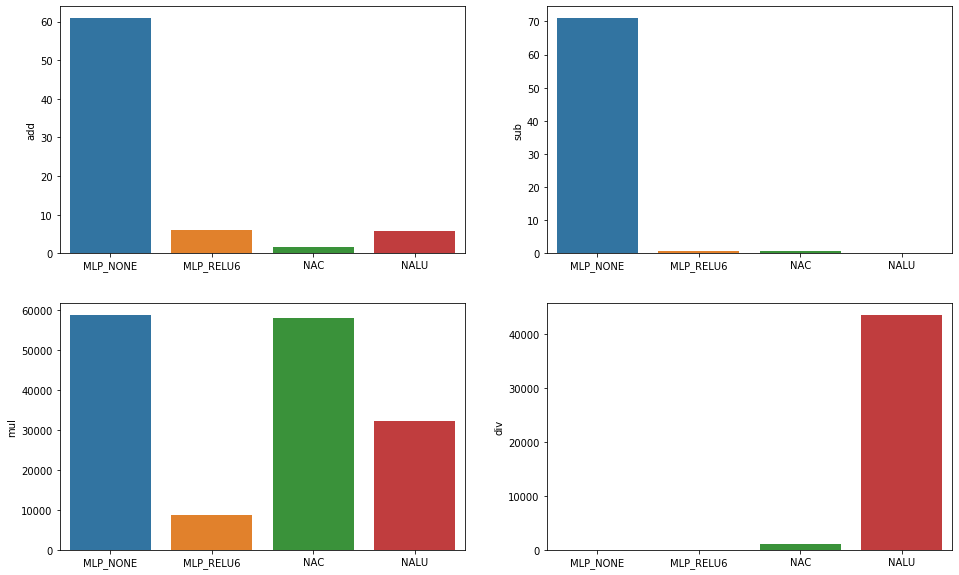

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
axs = axs.flatten()

sns.barplot(x=df_interp.index, y='add', data=df_interp, ax=axs[0])
sns.barplot(x=df_interp.index, y='sub', data=df_interp, ax=axs[1])
sns.barplot(x=df_interp.index, y='mul', data=df_interp, ax=axs[2])
sns.barplot(x=df_interp.index, y='div', data=df_interp, ax=axs[3])